In [1]:
import pandas as pd
import numpy as np
import os


In [2]:
pd.set_option('display.max_columns', None)

# Read datasets from the interim directory
X_train = pd.read_pickle("../../data/interim/X_train_ori.pkl")
X_val = pd.read_pickle("../../data/interim/X_val_ori.pkl")
X_test = pd.read_pickle("../../data/interim/X_test_ori.pkl")
y_train = pd.read_pickle("../../data/interim/y_train_ori.pkl")
y_val = pd.read_pickle("../../data/interim/y_val_ori.pkl")
y_test = pd.read_pickle("../../data/interim/y_test_ori.pkl")

In [3]:
'''
# collapse BSC, FKL, SDL, FOL into FALL
fall_labels = ['BSC', 'FKL', 'SDL', 'FOL']

y_train = y_train.apply(lambda x: x if x in fall_labels else 'ADL')
y_val = y_val.apply(lambda x: x if x in fall_labels else 'ADL')
y_test = y_test.apply(lambda x: x if x in fall_labels else 'ADL')

'''

"\n# collapse BSC, FKL, SDL, FOL into FALL\nfall_labels = ['BSC', 'FKL', 'SDL', 'FOL']\n\ny_train = y_train.apply(lambda x: x if x in fall_labels else 'ADL')\ny_val = y_val.apply(lambda x: x if x in fall_labels else 'ADL')\ny_test = y_test.apply(lambda x: x if x in fall_labels else 'ADL')\n\n"

In [4]:
y_train.unique()

['STD', 'WAL', 'LYI', 'STN', 'CSI', ..., 'CHU', 'SDL', 'JUM', 'JOG', 'FOL']
Length: 16
Categories (16, object): ['BSC', 'LYI', 'STD', 'CHU', ..., 'STU', 'SCH', 'SDL', 'STN']

### Segment into Windows

In [5]:
sensor_cols = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'azimuth','pitch','roll']

def create_windows(X, y, window_size=125, step_size=62): # 2.5 sec with 50% overlapping windows
    X_windows, y_windows = [], []
    
    for start in range(0, len(X) - window_size + 1, step_size):
        end = start + window_size
        window_data = X[start:end]
        window_labels = y[start:end]

        # Majority voting for label assignment
        unique, counts = np.unique(window_labels, return_counts=True)
        label = unique[np.argmax(counts)]

        X_windows.append(window_data)
        y_windows.append(label)

    return np.array(X_windows), np.array(y_windows)

In [6]:
X_train_windows, y_train_windows = create_windows(X_train, y_train)
X_val_windows, y_val_windows = create_windows(X_val, y_val)
X_test_windows, y_test_windows = create_windows(X_test, y_test)

In [7]:
X_train_windows.shape

(44862, 125, 9)

### Encode Label

In [8]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform on the windowed training labels
y_train_windows_encoded = le.fit_transform(y_train_windows)

# Transform the validation and test windowed labels based on the same encoding
y_val_windows_encoded = le.transform(y_val_windows)
y_test_windows_encoded = le.transform(y_test_windows)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.optimizers import Adam


# Implementation of "LSTM-CNN Architecture for Human Activity Recognition" by Kun Xia et al. (IEEE Access, 2020)
# Adapted from https://github.com/quotation2520/CAGE4HAR/blob/main/models/LSTM_CNN.py

## X_train_windows.shape == (n_samples, 100, 6)
input_shape = (X_train_windows.shape[1], X_train_windows.shape[2]) 
num_classes = len(set(y_train_windows_encoded))                  

model_lstm_conv = Sequential([

    # ——— LSTM stack ———
    # first LSTM returns full sequence
    LSTM(32, return_sequences=True, input_shape=input_shape),
    # second LSTM also returns full sequence
    LSTM(32, return_sequences=True),

    # ——— 1D‐Conv + Pool ———
    Conv1D(
        filters=64,
        kernel_size=5,
        strides=2,
        activation='relu',
        padding='valid'   # matches PyTorch default
    ),
    MaxPooling1D(pool_size=2, strides=2),

    # ——— second Conv block ———
    Conv1D(
        filters=128,
        kernel_size=3,
        strides=1,
        activation='relu',
        padding='valid'
    ),

    # ——— batch‐norm & spatial collapse ———
    BatchNormalization(),            # normalise over feature‐axis
    GlobalAveragePooling1D(),        # mean over time dimension

    # ——— classification head ———
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_lstm_conv.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_lstm_conv.summary()

c:\Users\sovan\Desktop\Fall Detection\fresh-ilab-fall-detection\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 125, 32)        │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 125, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 61, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 28, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,280 (200.31 KB)

 Trainable params: 51,024 (199.31 KB)

 Non-trainable params: 256 (1.00 KB)

In [10]:
history = model_lstm_conv.fit(X_train_windows, y_train_windows_encoded,
                    validation_data=(X_val_windows, y_val_windows_encoded),
                    epochs=25, batch_size=32)

Epoch 1/25
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 96s 65ms/step - accuracy: 0.7534 - loss: 0.8569 - val_accuracy: 0.7554 - val_loss: 0.7191
Epoch 2/25
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 90s 64ms/step - accuracy: 0.8887 - loss: 0.3514 - val_accuracy: 0.7645 - val_loss: 0.8099
Epoch 3/25
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 90s 64ms/step - accuracy: 0.9074 - loss: 0.2945 - val_accuracy: 0.7678 - val_loss: 0.7560
Epoch 4/25
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 91s 65ms/step - accuracy: 0.9214 - loss: 0.2506 - val_accuracy: 0.7549 - val_loss: 0.9077
Epoch 5/25
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 91s 65ms/step - accuracy: 0.9267 - loss: 0.2278 - val_accuracy: 0.7832 - val_loss: 0.7975
Epoch 6/25
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 91s 65ms/step - accuracy: 0.9281 - loss: 0.2209 - val_accuracy: 0.7942 - val_loss: 0.8301
Epoch 7/25
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 91s 65ms/step - accuracy: 0.9358 - loss: 0.2010 - val_accuracy: 0.8137 - val_loss: 0.7297
Epoch 8/25
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 93s 67ms/step - accuracy: 0.9424 -

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score)

def evaluate_model(model, X_test, y_test, label_classes=None, plot_confusion_matrix=True, plot_roc=True):

    # Evaluate the model for loss and accuracy
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss: {:.4f}".format(loss))
    print("Test Accuracy: {:.4f}".format(accuracy))

    # Generate prediction probabilities and predicted classes
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    if plot_confusion_matrix:
        plt.figure(figsize=(10, 8))
        if label_classes is None:
            label_classes = [str(i) for i in range(cm.shape[0])]
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
                    xticklabels=label_classes, yticklabels=label_classes)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

    # Compute and print classification report
    report = classification_report(y_test, y_pred, target_names=label_classes)
    print("Classification Report:\n", report)

    # Compute weighted precision, recall, and F1 scores
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Weighted Precision: {:.4f}".format(precision))
    print("Weighted Recall: {:.4f}".format(recall))
    print("Weighted F1 Score: {:.4f}".format(f1))

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    return metrics

Test Loss: 0.6853
Test Accuracy: 0.8542
452/452 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step


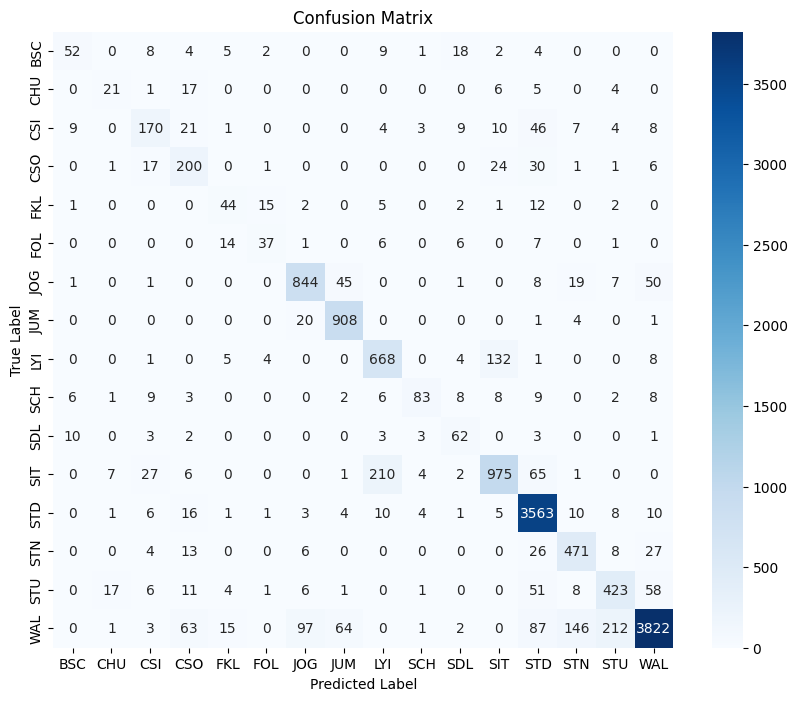

Classification Report:
               precision    recall  f1-score   support

         BSC       0.66      0.50      0.57       105
         CHU       0.43      0.39      0.41        54
         CSI       0.66      0.58      0.62       292
         CSO       0.56      0.71      0.63       281
         FKL       0.49      0.52      0.51        84
         FOL       0.61      0.51      0.56        72
         JOG       0.86      0.86      0.86       976
         JUM       0.89      0.97      0.93       934
         LYI       0.73      0.81      0.77       823
         SCH       0.83      0.57      0.68       145
         SDL       0.54      0.71      0.61        87
         SIT       0.84      0.75      0.79      1298
         STD       0.91      0.98      0.94      3643
         STN       0.71      0.85      0.77       555
         STU       0.63      0.72      0.67       587
         WAL       0.96      0.85      0.90      4513

    accuracy                           0.85     14449
  

In [12]:
label_classes = le.classes_.tolist()
metrics = evaluate_model(model_lstm_conv, X_test_windows, y_test_windows_encoded, label_classes=label_classes)

### 10 - Fold Cross Validation

In [ ]:
from sklearn.model_selection import GroupKFold

In [ ]:
# Read datasets from the interim directory
df_filtered = pd.read_pickle("../../data/interim/df_filtered.pkl")

In [ ]:
from tensorflow.keras import Input

def build_model(input_shape, num_classes):
    model_cnn_lstm = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        # The LSTM layer now interprets the feature maps temporally.
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
])

    model_cnn_lstm.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])
    return model_cnn_lstm

In [ ]:
sensor_cols = ['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z']
groups     = df_filtered['subject_id'].values
gkf        = GroupKFold(n_splits=10)

val_losses     = []
val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(
        gkf.split(df_filtered, df_filtered['label'], groups=groups)):

    # ----- 1) Select raw fold data -----
    df_tr = df_filtered.iloc[train_idx]
    df_va = df_filtered.iloc[val_idx]

    X_tr_raw = df_tr[sensor_cols].values
    y_tr_raw = df_tr['label'].values
    X_va_raw = df_va[sensor_cols].values
    y_va_raw = df_va['label'].values

    # ----- 2) Window -----
    X_train_windows, y_train_windows = create_windows(X_tr_raw, y_tr_raw,
                                                      window_size=50,
                                                      step_size=25)
    X_val_windows,   y_val_windows   = create_windows(X_va_raw, y_va_raw,
                                                      window_size=50,
                                                      step_size=25)

    # ----- 3) Encode labels -----
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train_windows)
    y_val_encoded   = le.transform(y_val_windows)

    # ----- 4) Build model -----
    input_shape = (X_train_windows.shape[1], X_train_windows.shape[2])  # (50,6)
    num_classes = len(le.classes_)

    model = build_model(input_shape, num_classes)

    # ----- 5) Train -----
    history = model.fit(
        X_train_windows, y_train_encoded,
        validation_data=(X_val_windows, y_val_encoded),
        epochs=25, batch_size=32, verbose=0
    )

    # ----- 6) Collect metrics -----
    val_loss = history.history['val_loss'][-1]
    val_acc  = history.history['val_accuracy'][-1]
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Fold {fold+1} — val_loss: {val_loss:.4f}, val_acc: {val_acc:.4%}")

# ----- 7) Aggregate across folds -----
mean_loss = np.mean(val_losses)
std_loss  = np.std(val_losses)
mean_acc  = np.mean(val_accuracies)
std_acc   = np.std(val_accuracies)

print("\n=== Cross‐Validation Results ===")
print(f"Val Loss: {mean_loss:.4f} ± {std_loss:.4f}")
print(f"Val Acc:  {mean_acc:.4%} ± {std_acc:.4%}")
